# Welcome!

In this notebook, we provide the code for running and collecting experimental results as described in the paper:

[**Sanity Checks Revisited: An Exploration to Repair the Model Parameter Randomisation Test**](https://openreview.net/forum?id=vVpefYmnsG) by Anna Hedström, Leander Weber, Sebastian Lapuschkin, Marina Höhne. 

Please note that this notebook assumes access to test sets for the `MNIST`, `fMNIST`, and `ImageNet` datasets. If you haven't generated the necessary data yet, please refer to our tutorial [here](https://github.com/annahedstroem/MetaQuantus/blob/main/tutorials/Tutorial-Data-Generation-Experiments.ipynb) to generate the required dataset.

Make sure to update file paths as needed before running the experiments (e.g., `nbs/results/benchmarking/` and `nbs/results/plots/`. Also enable GPU as some experiments are quite computationally costly.


### Imports

In [1]:
from IPython.display import clear_output
!pip install -r ../requirements.txt
clear_output()

In [2]:
# Load supporting functions.
import sys
sys.path.append('../')
from src import *

# Import libraries.
from typing import List
import time
import pickle
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import quantus

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
try:
    print('Using device:', torch.cuda.get_device_name(0))
    !nvidia-smi
except:
    pass

In [3]:
# Set paths to datasets and to write results.
path_assets =  "../../MetaQuantus/assets/"
path_results = "results/"

## MPRT vs eMPRT analysis

This cell loads datasets, models, explanations and parameterise the metrics.

In [4]:
# Load datasets, models and explanations.
datasets = {
    "MNIST_LeNet": {
        "batch_size": 1000,
        "full_size": 1000,
        "fig_size": (4, 4),
    },
    "fMNIST_LeNet": {
        "batch_size": 1000,
        "full_size": 1000,
        "fig_size": (4, 4),
    },
    "ImageNet_ResNet18": {
        "batch_size": 100,
        "full_size": 300,
        "fig_size": (8, 4),
    },
    "ImageNet_VGG16": {
        "batch_size": 25,
        "full_size": 300,
        "fig_size": (8, 4),
    },
}
xai_methods = [
    "Control Var. Random Uniform",
    "Gradient",
    "Saliency",
    "LayerGradCam",
    "SmoothGrad",
    "IntegratedGradients",
    "LRP-Eps",
    "LRP-Z+",
    "Guided-Backprop",
    "GradientShap",
    "InputXGradient",
]

# Parameterise the metrics.
metrics = [
    quantus.EfficientMPRT(
        layer_order="bottom_up",
        complexity_func=quantus.complexity_func.discrete_entropy,
        complexity_func_kwargs={"n_bins": 100},
        similarity_func=quantus.correlation_spearman,
        skip_layers=False,
        abs=False,
        normalise=True,
        normalise_func=quantus.normalise_by_average_second_moment_estimate,
        disable_warnings=True,
        compute_extra_scores=True,
    ),
    quantus.SmoothMPRT(
        layer_order="bottom_up",
        nr_samples=50,
        noise_magnitude=0.1,
        similarity_func=quantus.correlation_spearman,
        skip_layers=False,
        abs=True,
        normalise=True,
        normalise_func=quantus.normalise_by_average_second_moment_estimate,
        disable_warnings=True,
    ),
    quantus.MPRT(
        layer_order="top_down",
        similarity_func=quantus.correlation_spearman,
        skip_layers=False,
        abs=True,
        normalise=True,
        normalise_func=quantus.normalise_by_average_second_moment_estimate,
        disable_warnings=True,
    ),
]

#### Generate benchmarking results

In [5]:
debug = True
generate_data = False

if generate_data:
    for metric in metrics:

        torch.cuda.empty_cache()
        scores = {}
        for meta_name, meta_data in datasets.items():
            scores[meta_name] = {}
            dataset_name, model_name = meta_name.split("_")

            # Get datasst settings.
            dataset_settings = setup_experiments(
                dataset_name=dataset_name, path_assets=path_assets, device=device
            )
            estimator_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]
            dataset_kwargs = dataset_settings[dataset_name]

            # Get the model.
            model = dataset_kwargs["models"][model_name]

            # Setup for batch processing.
            nr_batches = int(meta_data["full_size"] / meta_data["batch_size"])

            temp_batches = {}
            for batch_id in range(nr_batches):

                # Get the data for the batch.
                start_idx = batch_id * meta_data["batch_size"]
                end_idx = start_idx + meta_data["batch_size"]
                x_batch = dataset_kwargs["x_batch"][start_idx:end_idx]
                y_batch = dataset_kwargs["y_batch"][start_idx:end_idx]
                s_batch = dataset_kwargs["s_batch"][start_idx:end_idx]

                # Update model-specific xai parameters.
                xai_methods_with_kwargs = {**setup_xai_methods_captum(
                    xai_methods=xai_methods,
                    x_batch=x_batch,
                    gc_layer=dataset_kwargs["gc_layers"][model_name],
                    img_size=estimator_kwargs["img_size"],
                    nr_channels=estimator_kwargs["nr_channels"],
                    nr_segments=50,
                ), **setup_xai_methods_zennit(xai_methods=xai_methods, model=model)}

                for xai_method, xai_method_kwargs in xai_methods_with_kwargs.items():

                    scores[meta_name][xai_method] = {}

                    if batch_id == 0:
                        temp_batches[xai_method] = {
                            "model_scores": [], 
                            "explanation_scores": [], 
                            "correlation_scores": [],
                            "evaluation_scores": [],
                            "similarity_scores": [],
                        }

                    if debug:
                        start = time.time()
                        print(f"batch id {batch_id} - {xai_method} ({model_name}, {dataset_name})")

                    metric.abs = True
                    if xai_method == "SmoothGrad":
                        metric.abs = True

                    # Score!
                    evaluation_scores = metric(model=model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        softmax=True,
                        a_batch=None,
                        device=device,
                        explain_func=quantus.explain,
                        explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs},
                    )

                    # Save intermediate batch results.
                    try:
                        temp_batches[xai_method]["model_scores"].append(metric.model_scores_by_layer)
                        temp_batches[xai_method]["explanation_scores"].append(metric.explanation_scores_by_layer)
                        temp_batches[xai_method]["correlation_scores"].extend(metric.scores_extra["scores_correlation_model_vs_explanation_complexity"])
                    except Exception as e:
                        print(f"Error message: {e}")

                    if metric.name != "Model Parameter Randomisation Test":
                        temp_batches[xai_method]["similarity_scores"].extend(evaluation_scores)
                    else:
                        temp_batches[xai_method]["evaluation_scores"].extend(evaluation_scores)

                    if debug:
                        for k, v in temp_batches[xai_method].items():
                            try:
                                if all((isinstance(val, (int, float)) and (val == 0 or np.isnan(val))) for val in v):
                                    print(f"\t\tWarning: '{k}' - with all NaNs or zeros!")
                            except TypeError:
                                pass 
                            if isinstance(v, list) and not v:
                                print(f"\t\tWarning:{k} - list is empty!")

                        print(f"\t\t\t{evaluation_scores}")
                        print(f"\tTime to compute {time.time()-start:.2f} secs.")

                    torch.cuda.empty_cache()

            # Merge dictionaries for different batches.
            for xai_method, xai_method_kwargs in xai_methods_with_kwargs.items():
                for k in temp_batches[xai_method].keys():
                    if isinstance(temp_batches[xai_method][k][0], dict):

                        # Merge all dicts according the the same key!
                        merged_dict = defaultdict(list)
                        for d in temp_batches[xai_method][k]:
                            for inner_k, v in d.items():

                                # Extend the list of float values.
                                merged_dict[inner_k].extend(v)  

                        # Replace the list of dictionaries with the merged dictionary.
                        temp_batches[xai_method][k] = dict(merged_dict)

            # Put the results back to scores dictionary.
            for xai_method, xai_method_kwargs in xai_methods_with_kwargs.items():
                for k in temp_batches[xai_method].keys():
                    scores[meta_name][xai_method] = temp_batches[xai_method]

        # Save data for each metric.
        with open(path_results+f"{metric.name}_curves_scores.pickle", 'wb') as f:
            pickle.dump(scores, f)

### Plot MPRT and eMPRT curves

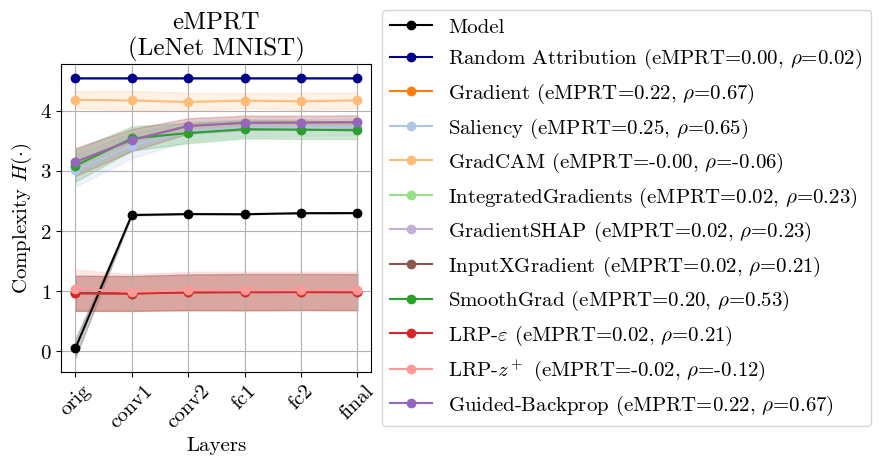

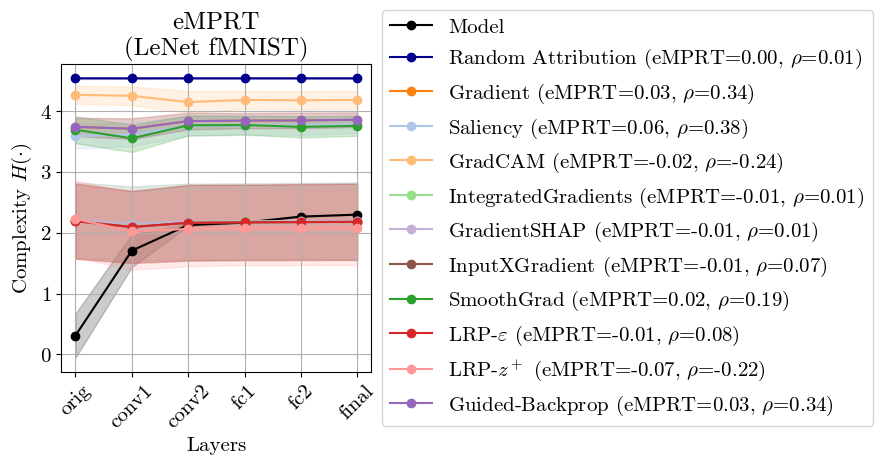

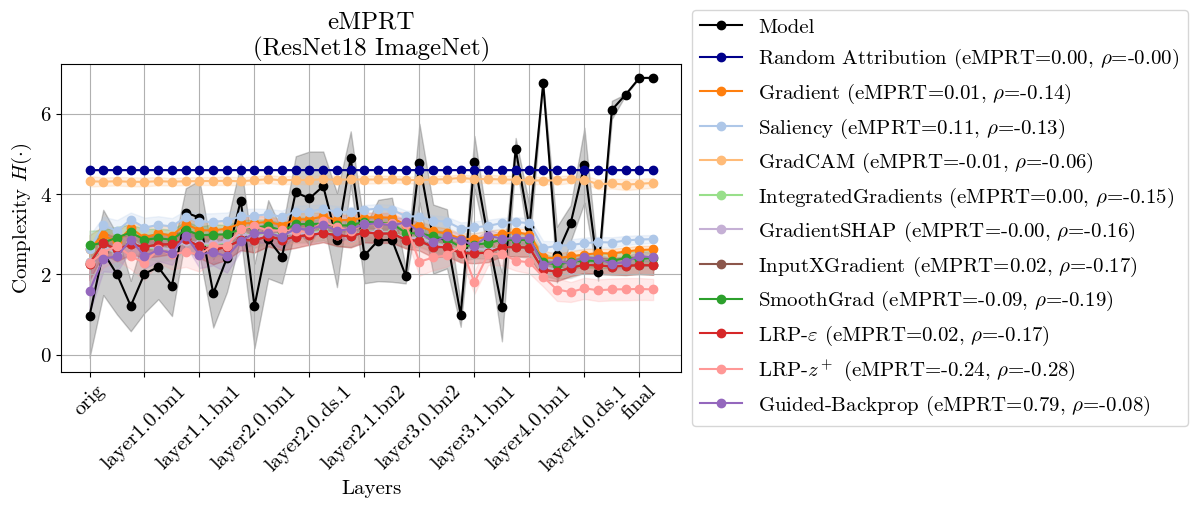

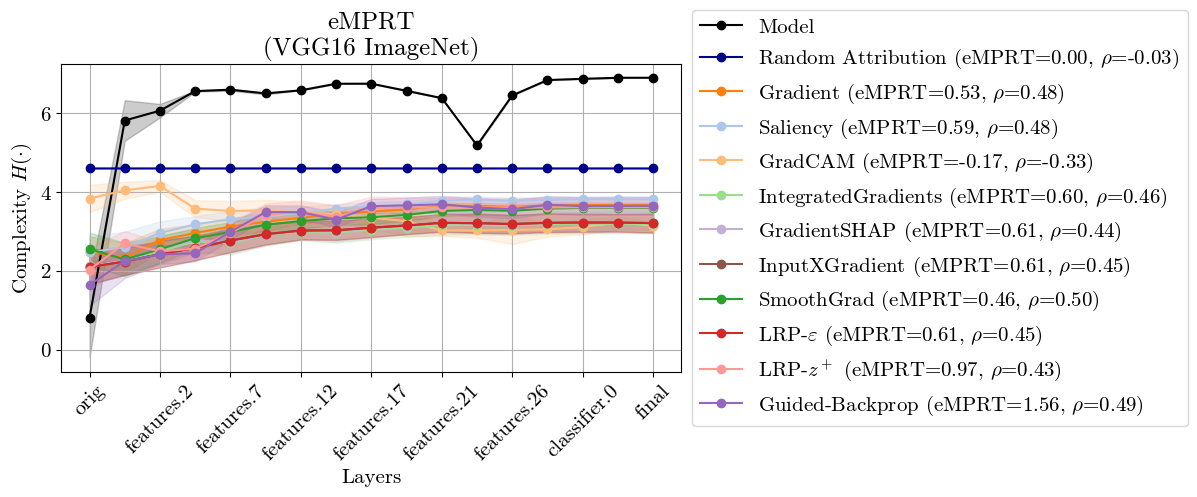

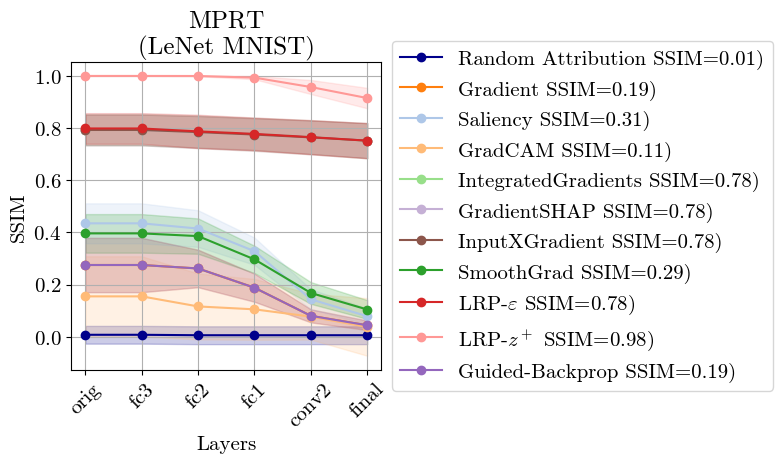

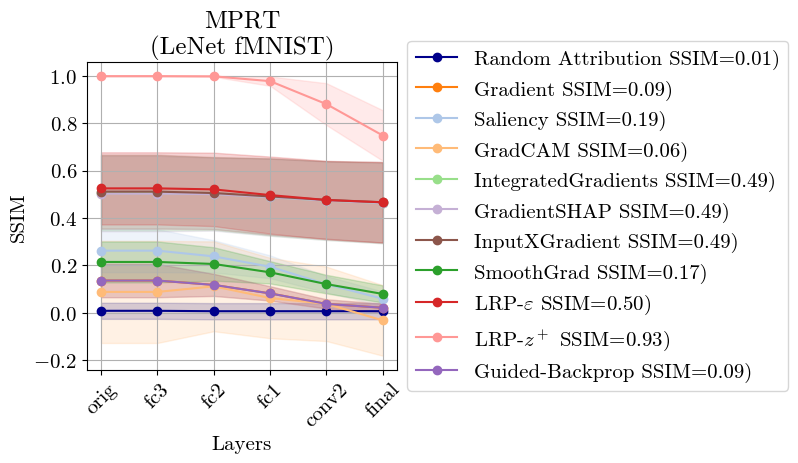

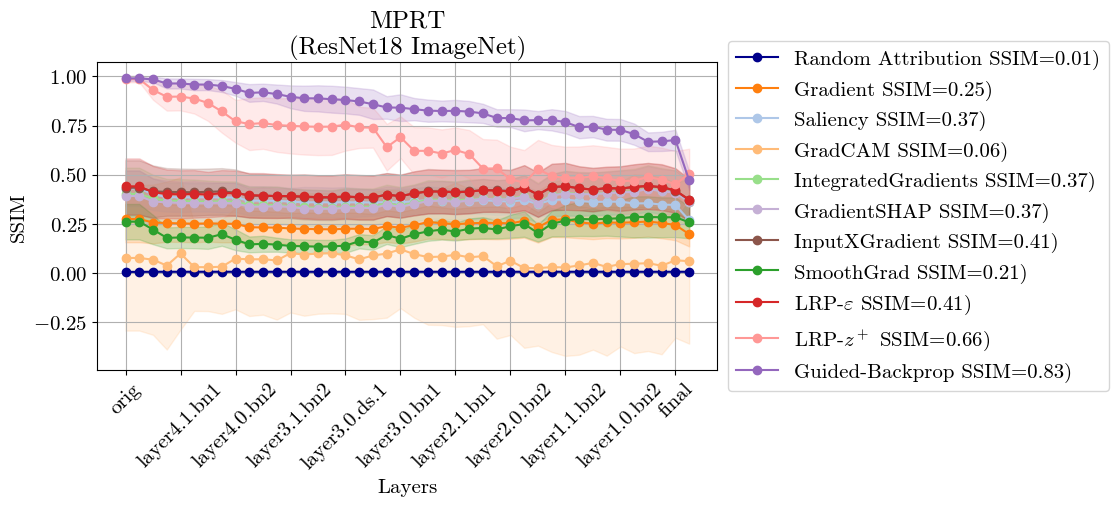

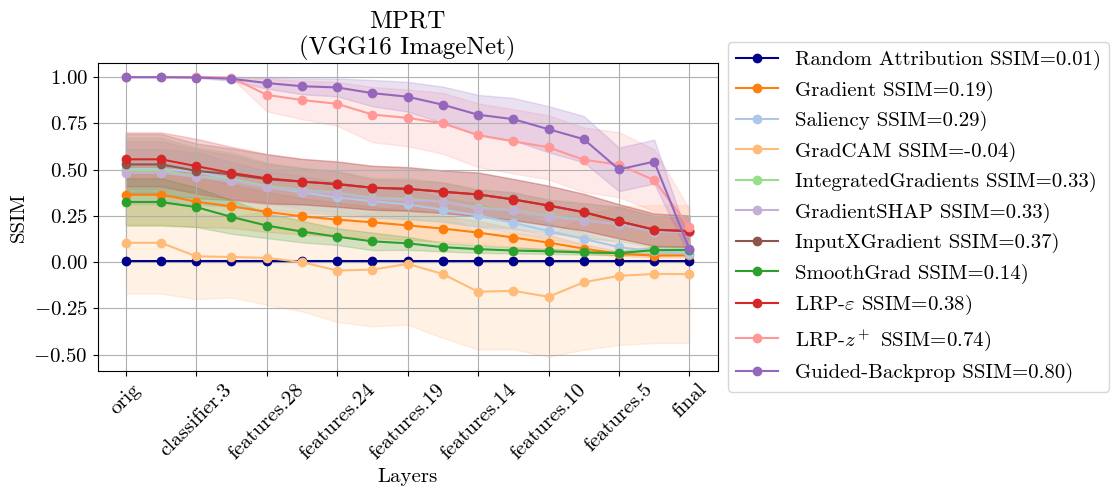

In [6]:

def plot_curves(
    path_results: str,
    datasets: dict,
    metric_name: str = "MPRT",
    plotting_func: Callable = plot_randomisation_curves,
):
    """
    Plot eMPRT and MPRT curves for different methods.

    Parameters
    ----------
    path_results: str
        The path to where to store the results.
    datasets: dict
        The datasets to use.
    metric_name: str, optional
        The name of the metric. Default is "MPRT".
    plotting_func: Callable, optional
        The plotting function to use. Default is `plot_randomisation_curves`.

    Returns
    -------

    """
    # Load data.
    with open(path_results + f"{metric_name}_curves_scores.pickle", "rb") as f:
        scores = pickle.load(f)

    for meta_name, meta_data in datasets.items():
        dataset_name, model_name = meta_name.split("_")

        # Plot!
        plot_randomisation_curves(
            scores[meta_name],
            dataset_name,
            model_name,
            metric_name=metric_name,
            figsize=meta_data["fig_size"],
        )  # (10, 6)) (min(len(list(model.modules())), 10), 4)

        plt.savefig(
            path_results + f"plots/{metric_name}_curves_{dataset_name}_{model_name}.svg"
        )
        plt.savefig(
            path_results + f"plots/{metric_name}_curves_{dataset_name}_{model_name}.pdf"
        )
        plt.show()


plot_curves(path_results, datasets=datasets, metric_name="eMPRT")
plot_curves(path_results, datasets=datasets, metric_name="MPRT")

### Plot eMPRT aggregation over tasks

/var/folders/w2/h9z278fs179f393h2jbj3y_80000gn/T/ipykernel_62916/1044275856.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  means = df_ranking.applymap(lambda x: float(x.split(" $\\pm$ ")[0]))
/var/folders/w2/h9z278fs179f393h2jbj3y_80000gn/T/ipykernel_62916/1044275856.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stds = df_ranking.applymap(lambda x: float(x.split(" $\\pm$ ")[1]))


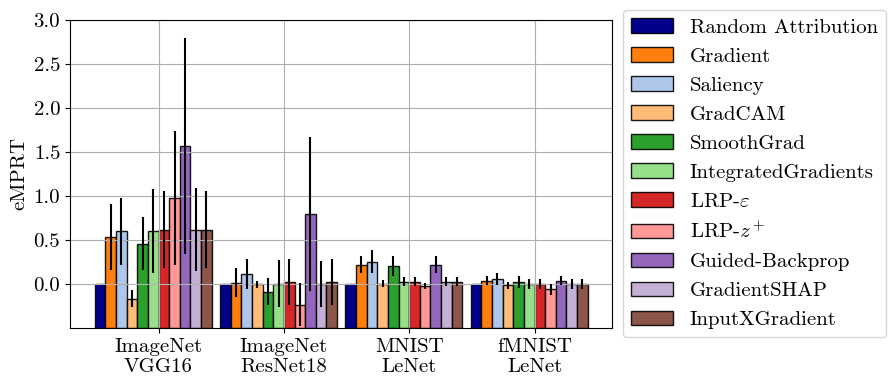

In [7]:

# Load eMPRT data.
with open(path_results + f"eMPRT_curves_scores.pickle", "rb") as f:
    scores_emprt = pickle.load(f)

# Restructure data.
scores_df = {}
for meta_name, meta_data in datasets.items():
    scores_df[meta_name] = {}
    for xai_method in xai_methods:
        emprt_scores = scores_emprt[meta_name][xai_method]["rate_of_change_scores"]
        scores_df[meta_name][
            xai_method
        ] = f"{np.mean(emprt_scores):.3f} $\pm$ {np.std(emprt_scores):.3f}"

# Get the rankings.
df_ranking = pd.DataFrame(scores_df)
df_ranking = df_ranking[
    ["ImageNet_VGG16", "ImageNet_ResNet18", "MNIST_LeNet", "fMNIST_LeNet"]
]
means = df_ranking.applymap(lambda x: float(x.split(" $\\pm$ ")[0]))
stds = df_ranking.applymap(lambda x: float(x.split(" $\\pm$ ")[1]))

# Configs.
num_methods = len(df_ranking.index)
bar_width = 0.085
r = np.arange(len(df_ranking.columns))
bottom = 0.5

# Plot bar!
fig, axs = plt.subplots(1, 1, figsize=(7, 4))

for idx, method in enumerate(df_ranking.index):
    plt.bar(
        r + idx * bar_width,
        means.loc[method] + bottom,
        width=bar_width,
        color=COLOR_MAP[method],
        edgecolor=(0, 0, 0, 0.9),
        label=LABEL_MAP[method],
        yerr=stds.loc[method],
    )  # , alpha=0.9) #hatch=hatches

y_labels = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
plt.yticks(ticks=[l + bottom for l in y_labels], labels=np.array(y_labels).astype(str))
x_labels = [f'{c.split("_")[0]}\n{c.split("_")[1]}' for c in df_ranking.columns]
plt.xticks(
    [r + bar_width * (num_methods / 2) for r in range(len(df_ranking.columns))],
    x_labels,
)
# plt.ylim(0, 3.7)
plt.ylabel("eMPRT")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig(path_results + f"plots/eMPRT_benchmarking.svg")
plt.savefig(path_results + f"plots/eMPRT_benchmarking.pdf")
plt.show()

### Plot MPRT vs eMPRT difference in relative ranking 

In [10]:
def get_df(scores: dict, datasets: dict, xai_methods: List[str], key: str) -> pd.DataFrame:
    """
    Get a dataframe from scores.

    Parameters
    ----------
    scores: dict
        The scores that is structured in xai
    datasets: dict
        The datasets to use.
    xai_methods: List[str]
        The xai methods to use.
    key: str
        The key to use for the scores.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the scores.
    """
    scores_df = {}
    for meta_name, meta_data in datasets.items():
        scores_df[meta_name] = {}
        for xai_method in xai_methods:
            emprt_scores = scores[meta_name][xai_method][key]
            scores_df[meta_name][
                xai_method
            ] = f"{np.mean(emprt_scores):.10f} $\pm$ {np.std(emprt_scores):.10f}"

    return pd.DataFrame(scores_df)


# Load MPRT data.
with open(path_results + f"MPRT_curves_scores.pickle", "rb") as f:
    scores_mprt = pickle.load(f)

# Load the MPRT data.
df_mprt = get_df(
    scores=scores_mprt,
    datasets=datasets,
    xai_methods=xai_methods,
    key="evaluation_scores",
)
df_mprt

,MNIST_LeNet,fMNIST_LeNet,ImageNet_ResNet18,ImageNet_VGG16
Control Var. Random Uniform,0.0057091117 $\pm$ 0.0342375587,0.0057091117 $\pm$ 0.0342375587,0.0058230958 $\pm$ 0.0041514881,0.0057646629 $\pm$ 0.0050466254
Gradient,0.0438381918 $\pm$ 0.0181295283,0.0202314744 $\pm$ 0.0172291574,0.1972071129 $\pm$ 0.0625889488,0.0367357139 $\pm$ 0.0095263855
Saliency,0.0784974563 $\pm$ 0.0301674677,0.0583896369 $\pm$ 0.0304857458,0.2677476843 $\pm$ 0.0377009874,0.0460918342 $\pm$ 0.0124546967
LayerGradCam,0.0373640019 $\pm$ 0.1103248072,-0.0333209419 $\pm$ 0.1491420181,0.0596391626 $\pm$ 0.4199910845,-0.0647311284 $\pm$ 0.3722861348
SmoothGrad,0.1042830310 $\pm$ 0.0361570854,0.0785200752 $\pm$ 0.0361003915,0.2575162946 $\pm$ 0.0813701073,0.0650331527 $\pm$ 0.0158292803
IntegratedGradients,0.7510602129 $\pm$ 0.0666851405,0.4626692868 $\pm$ 0.1698551416,0.3617687478 $\pm$ 0.1082643638,0.1660514839 $\pm$ 0.0885292779
LRP-Eps,0.7513763279 $\pm$ 0.0675529800,0.4657321887 $\pm$ 0.1701684295,0.3729101644 $\pm$ 0.1063513406,0.1667531913 $\pm$ 0.0835665867
LRP-Z+,0.9147030679 $\pm$ 0.0390680076,0.7477627812 $\pm$ 0.1068065141,0.5055679441 $\pm$ 0.1267337077,0.1897749578 $\pm$ 0.0953333703
Guided-Backprop,0.0438381919 $\pm$ 0.0181295283,0.0202314744 $\pm$ 0.0172291573,0.4707874571 $\pm$ 0.0468667128,0.0703103585 $\pm$ 0.0395668229
GradientShap,0.7517280490 $\pm$ 0.0667508156,0.4623424814 $\pm$ 0.1696871102,0.3608452728 $\pm$ 0.1057578675,0.1608102583 $\pm$ 0.0844073153


In [11]:
# Load the eMPRT data.
df_emprt = get_df(scores=scores_emprt, datasets=datasets, xai_methods=xai_methods, key="rate_of_change_scores")
df_emprt

,MNIST_LeNet,fMNIST_LeNet,ImageNet_ResNet18,ImageNet_VGG16
Control Var. Random Uniform,0.0000000000 $\pm$ 0.0000000000,0.0000000000 $\pm$ 0.0000000000,0.0000000000 $\pm$ 0.0000000000,0.0000000000 $\pm$ 0.0000000000
Gradient,0.2164980709 $\pm$ 0.0987235732,0.0329006358 $\pm$ 0.0498064617,0.0117647639 $\pm$ 0.1658422921,0.5256199158 $\pm$ 0.3740838356
Saliency,0.2504863141 $\pm$ 0.1269425047,0.0564705728 $\pm$ 0.0691771817,0.1126513010 $\pm$ 0.1701955953,0.5934101659 $\pm$ 0.3818929711
LayerGradCam,-0.0020511526 $\pm$ 0.0367224088,-0.0187970439 $\pm$ 0.0407175920,-0.0086171079 $\pm$ 0.0434288829,-0.1707409927 $\pm$ 0.0933699410
SmoothGrad,0.1999675553 $\pm$ 0.1172378403,0.0203181617 $\pm$ 0.0709119443,-0.0919924669 $\pm$ 0.1540747297,0.4550920461 $\pm$ 0.3019079828
IntegratedGradients,0.0216683503 $\pm$ 0.0486227626,-0.0060853573 $\pm$ 0.0562673313,0.0001802297 $\pm$ 0.2707384165,0.5982645777 $\pm$ 0.4729834797
LRP-Eps,0.0201960010 $\pm$ 0.0485170715,-0.0055936697 $\pm$ 0.0564379644,0.0197703941 $\pm$ 0.2639749804,0.6103624004 $\pm$ 0.4384643754
LRP-Z+,-0.0246491262 $\pm$ 0.0325235782,-0.0670853371 $\pm$ 0.0575807454,-0.2417354318 $\pm$ 0.2444003074,0.9713556623 $\pm$ 0.7576417372
Guided-Backprop,0.2164983863 $\pm$ 0.0987237001,0.0329011010 $\pm$ 0.0498065118,0.7876316278 $\pm$ 0.8727930941,1.5595984042 $\pm$ 1.2252788557
GradientShap,0.0221553567 $\pm$ 0.0492100560,-0.0070927008 $\pm$ 0.0565803459,-0.0014734454 $\pm$ 0.2629596290,0.6130703676 $\pm$ 0.4749901501


/var/folders/w2/h9z278fs179f393h2jbj3y_80000gn/T/ipykernel_62916/3257715560.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  means_emprt = df_emprt.applymap(lambda x: float(x.split(" $\\pm$ ")[0]))
/var/folders/w2/h9z278fs179f393h2jbj3y_80000gn/T/ipykernel_62916/3257715560.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  means_mprt = df_mprt.applymap(lambda x: float(x.split(" $\\pm$ ")[0]))
/var/folders/w2/h9z278fs179f393h2jbj3y_80000gn/T/ipykernel_62916/3257715560.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(labels=["MPRT", "eMPRT"], rotation=45)
/var/folders/w2/h9z278fs179f393h2jbj3y_80000gn/T/ipykernel_62916/3257715560.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(labels=["

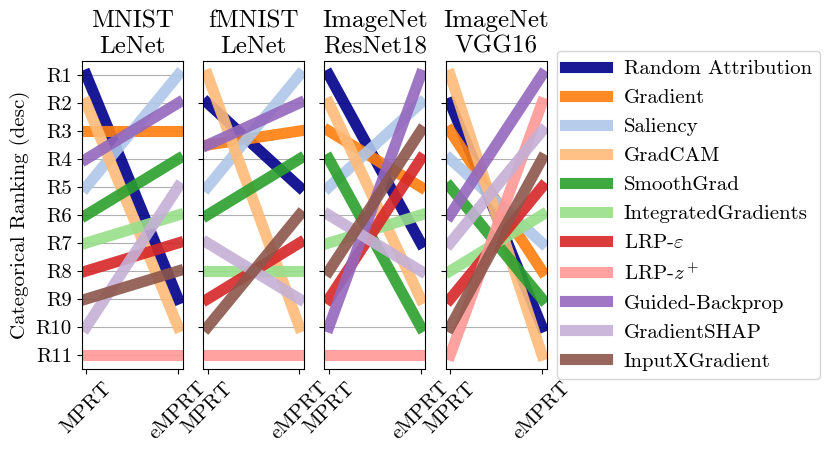

In [12]:
# Extract means.
means_emprt = df_emprt.applymap(lambda x: float(x.split(" $\\pm$ ")[0]))
means_mprt = df_mprt.applymap(lambda x: float(x.split(" $\\pm$ ")[0]))

# Rank the methods based on the scores.
mprt_ranks = means_mprt.rank(axis=0, ascending=True)
emprt_ranks = means_emprt.rank(axis=0, ascending=False)

# Plot ranking!
fig, axs = plt.subplots(1, len(datasets), figsize=(6, 4))

labels = [f'{c.split("_")[0]}\n{c.split("_")[1]}' for c in df_emprt.columns]
for idx, dataset in enumerate(datasets):
    for xai_method in mprt_ranks.index:
        axs[idx].plot(
            ["MPRT", "eMPRT"],
            [mprt_ranks.loc[xai_method, dataset], emprt_ranks.loc[xai_method, dataset]],
            label=LABEL_MAP[xai_method],
            color=COLOR_MAP[xai_method],
            linestyle="-",
            linewidth=8,
            alpha=0.9,
        )

    axs[idx].set_title(f"{labels[idx]}")
    axs[idx].invert_yaxis()
    axs[idx].grid(axis="y")
    axs[idx].set_xticklabels(labels=["MPRT", "eMPRT"], rotation=45)

    if idx > 0:
        axs[idx].set_yticklabels([])
        axs[idx].set_ylabel("")
    else:
        axs[idx].set_yticks(
            labels=["R" + str(int(i)) for i in np.arange(1, 12)],
            ticks=[i for i in np.arange(1, 12)],
        )

axs[-1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel("Categorical Ranking (desc)")
plt.savefig(path_results + f"plots/MPRT_vs_eMPRT_ranking.svg", bbox_inches="tight")
plt.savefig(path_results + f"plots/MPRT_vs_eMPRT_ranking.pdf", bbox_inches="tight")
plt.show()

### Benchmarking

Make sure to enable GPU for benchmarking, e.g., via colab or cluster environment.

In [13]:
# Experimental setup for benchmarking.
xai_methods = {
    "G_GC": ["Gradient", "LayerGradCam"],
    "SA_LRPplus_IXG": ["Saliency", "LRP-Z+", "InputXGradient"],
    "G_GC_LRPeps_GB": ["Gradient", "LayerGradCam", "LRP-Eps", "Guided-Backprop"],
    "GP_GS_GC_LRP-Eps_SA": [
        "Guided-Backprop",
        "GradientShap",
        "LayerGradCam",
        "LRP-Eps",
        "Saliency",
    ],
    "full_set": [
        "Gradient",
        "Saliency",
        "LayerGradCam",
        "SmoothGrad",
        "IntegratedGradients",
        "LRP-Eps",
        "LRP-Z+",
        "Guided-Backprop",
        "GradientShap",
        "InputXGradient",
    ],
}
datasets = {
    "MNIST": {
        "model_name": "LeNet",
        "indices": [[0, 1000]],
    },
    "fMNIST": {
        "model_name": "LeNet",
        "indices": [[0, 1000]],
    },
    "ImageNet_ResNet18": {
        "model_name": "ResNet18",
        "indices": get_indices(batch_size=100),
    },
    "ImageNet_VGG16": {
        "model_name": "VGG16",
        "indices": get_indices(batch_size=25),
    },
}

In [ ]:
# Run benchmarking.
xai_round = "G_GC"
fname = xai_round + ""

if __name__ == "__main__":
    for task_name, meta in datasets.items():
        dataset_name = task_name.split("_")[0]
        for i in range(len(meta["indices"])):
            torch.cuda.empty_cache()
            start_idx, end_idx = meta["indices"][i][0], meta["indices"][i][1]
            benchmark = run_benchmarking_script(
                dataset_name=dataset_name,
                model_name=meta["model_name"],
                K=str(5),
                iters=str(3),
                xai_methods=xai_methods[xai_round],
                normalise=True,
                start_idx=str(start_idx),
                end_idx=str(end_idx),
                path_assets=path_assets,
                path_results=path_results,
                setup_metrics=setup_estimators,
                folder="benchmarking/"+"task_name",
                fname_addition=fname,
            )
            torch.cuda.empty_cache()

### Analyse the results

#### M1 - Gradient Shap and Integrated Gradients

In [59]:
!ls results/benchmarking/Imagenet_VGG16/GS_IG

batch_1  batch_11 batch_2  batch_4  batch_6  batch_8
batch_10 batch_12 batch_3  batch_5  batch_7  batch_9


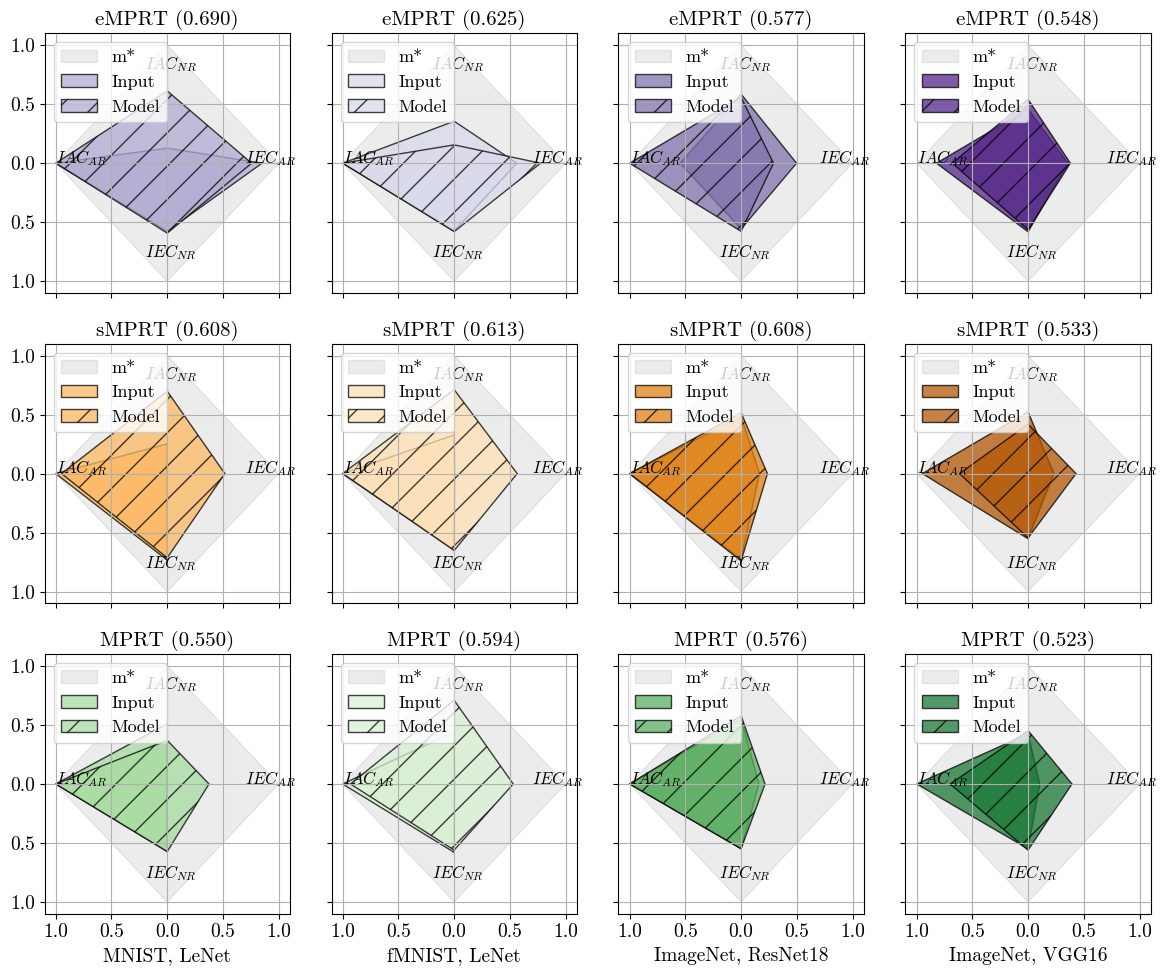

In [73]:
# Prepare the benchmarking data and plot!
xai_round = "GS_IG"
benchmarks_m2, xai_set = prepare_benchmarking_results(path_results, xai_round, setup_estimators)
prepare_and_plot_area_graph(benchmarks=benchmarks_m2, xai_set=xai_set, path_results=path_results, suffix="_final")

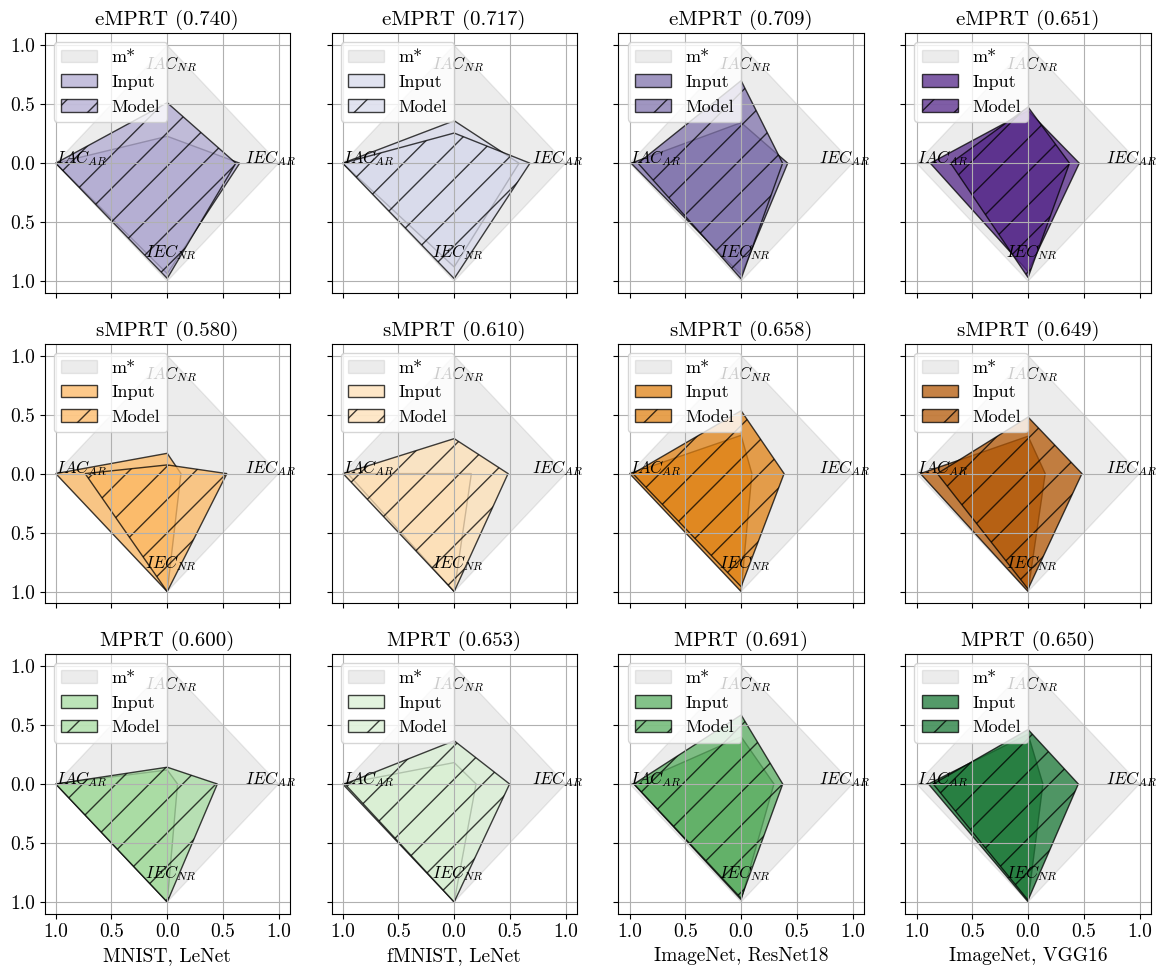

In [74]:
# Prepare the benchmarking data and plot!
xai_round = "SA_LRPplus_IXG"
benchmarks_m3, xai_set = prepare_benchmarking_results(path_results, xai_round, setup_estimators)
prepare_and_plot_area_graph(benchmarks=benchmarks_m3, xai_set=xai_set, path_results=path_results, suffix="_final")

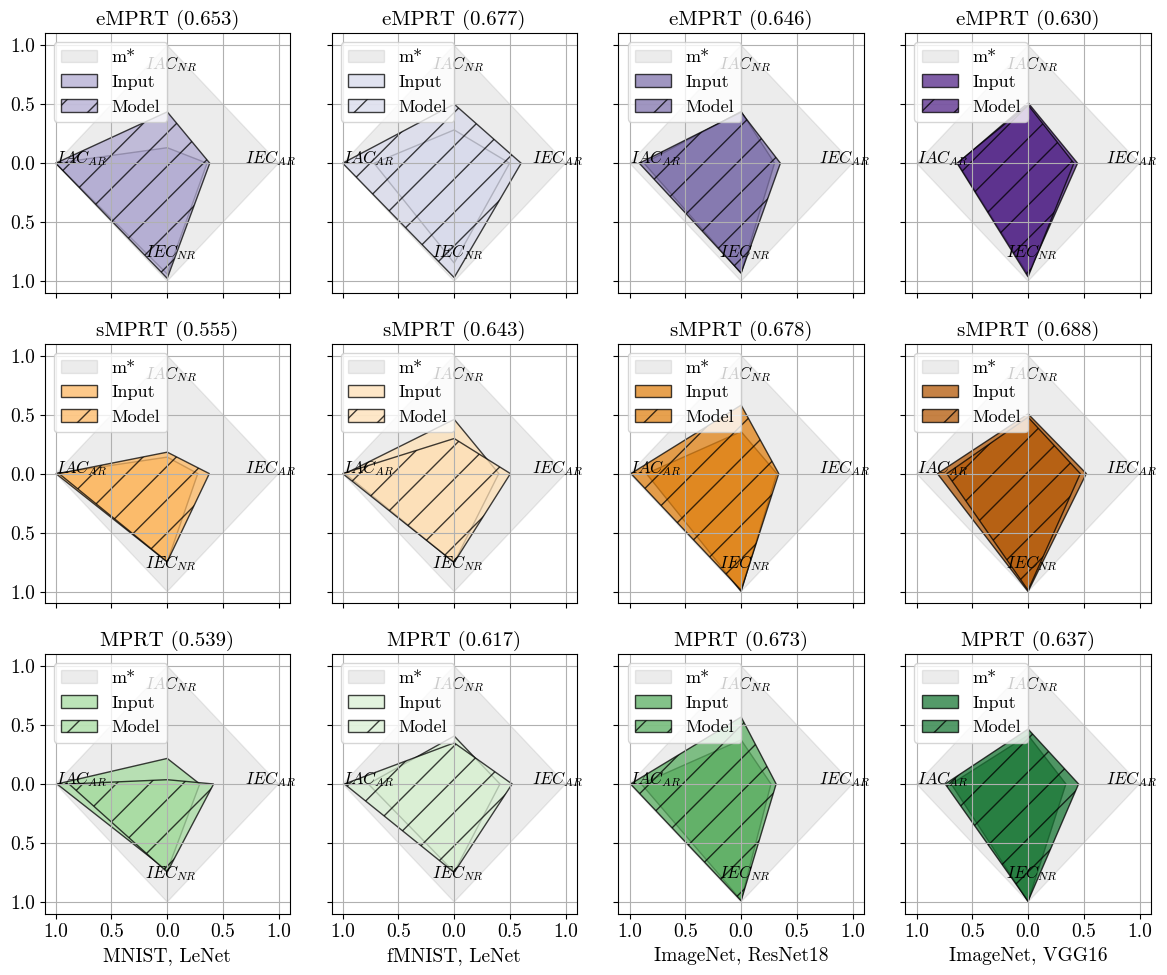

In [81]:
# Prepare the benchmarking data and plot!
xai_round = "G_GC_LRPeps_GB"
benchmarks_m4, xai_set = prepare_benchmarking_results(path_results, xai_round, setup_estimators)
prepare_and_plot_area_graph(benchmarks=benchmarks_m4, xai_set=xai_set, path_results=path_results, suffix="_final")

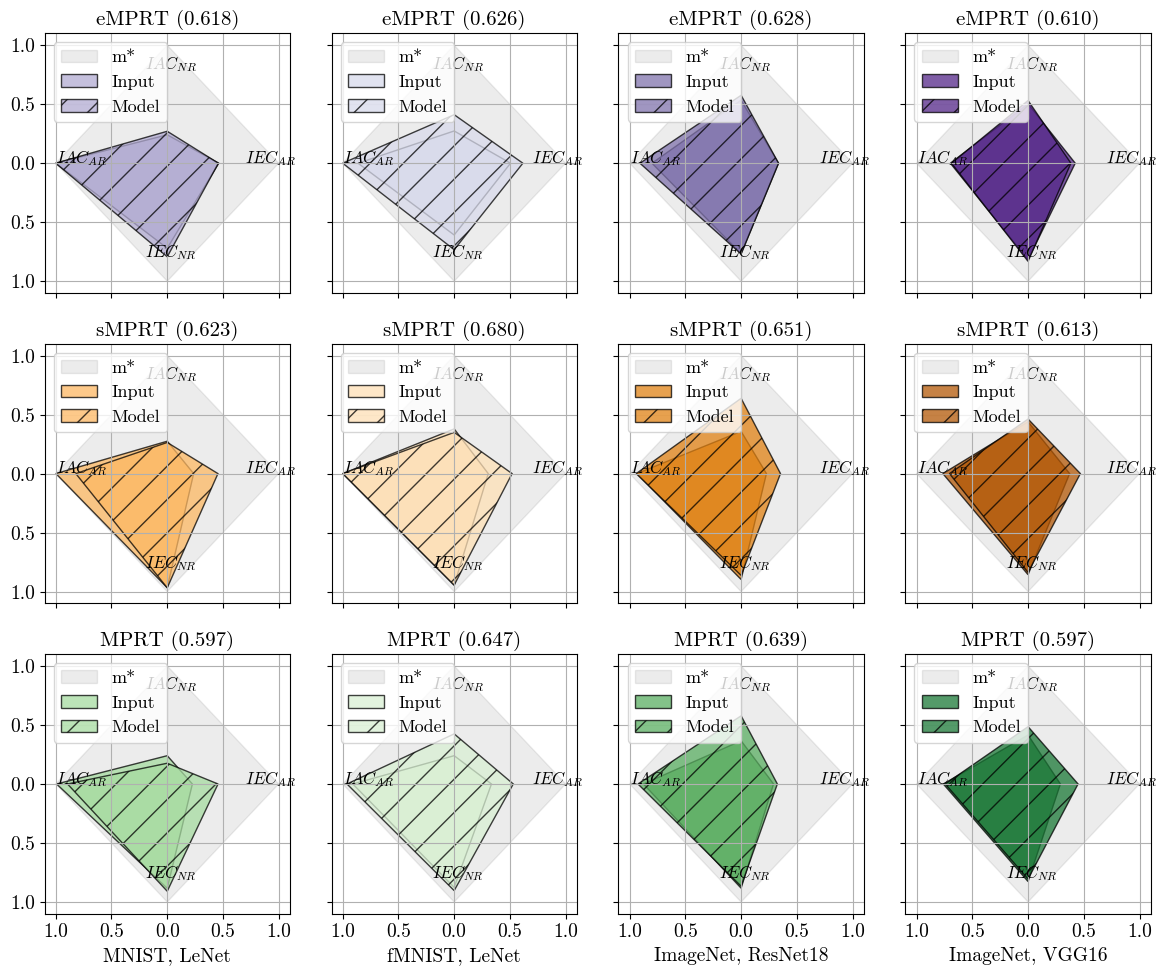

In [82]:
# Prepare the benchmarking data and plot!
xai_round = "GP_GS_GC_LRP-Eps_SA"
benchmarks_m5, xai_set = prepare_benchmarking_results(path_results, xai_round, setup_estimators)
prepare_and_plot_area_graph(benchmarks=benchmarks_m5, xai_set=xai_set, path_results=path_results, suffix="_final")

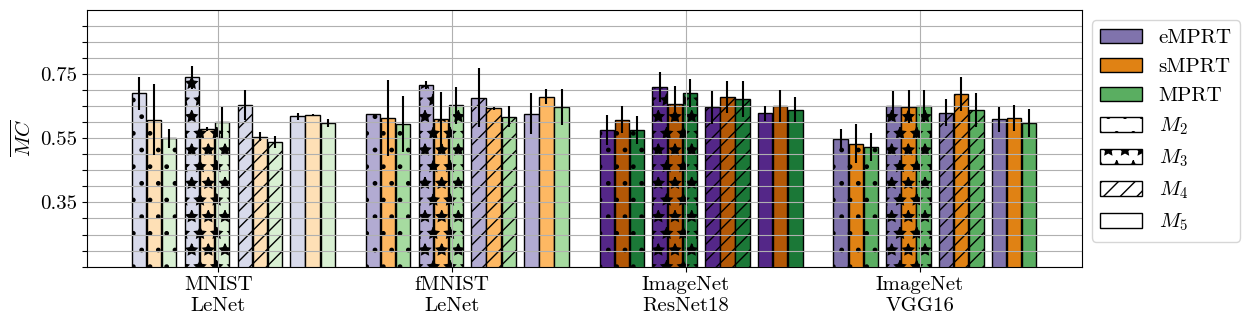

In [87]:
all_benchmarks = {**benchmarks_m2, **benchmarks_m3, **benchmarks_m4, **benchmarks_m5}
metrics = ["eMPRT", "sMPRT", "MPRT"]
results = get_results_bar(all_benchmarks, path_results)
plot_hierarchical_bar(
    data, metrics, path_results, suffix="_final", ystart=0.15, yend=0.95
)

In [88]:
# Create the table.
df_results = pd.DataFrame(results).T
df_results["Setting"] = df_results.index
df_results.index = np.arange(len(df_results))
df_results["M"] = df_results["Setting"].apply(lambda x: (x.split('_')[-1]))
df_results["Setting"] = df_results["Setting"].apply(lambda x: (str(x.split('_')[0])+" "+str(x.split('_')[1])))
df_results.sort_values("Setting", ascending=False, inplace=True)
df_results

,eMPRT,sMPRT,MPRT,Setting,M
4,0.625 $\pm$ 0.002,0.613 $\pm$ 0.119,0.594 $\pm$ 0.088,fMNIST LeNet,GSxIG
5,0.717 $\pm$ 0.012,0.61 $\pm$ 0.083,0.653 $\pm$ 0.058,fMNIST LeNet,SAxLRPplusxIXG
6,0.677 $\pm$ 0.091,0.643 $\pm$ 0.005,0.617 $\pm$ 0.033,fMNIST LeNet,GxGCxLRPepsxGB
7,0.626 $\pm$ 0.064,0.68 $\pm$ 0.023,0.647 $\pm$ 0.057,fMNIST LeNet,GPxGSxGCxLRPepsxSA
0,0.69 $\pm$ 0.051,0.608 $\pm$ 0.111,0.55 $\pm$ 0.03,MNIST LeNet,GSxIG
1,0.74 $\pm$ 0.036,0.58 $\pm$ 0.006,0.6 $\pm$ 0.048,MNIST LeNet,SAxLRPplusxIXG
2,0.653 $\pm$ 0.046,0.555 $\pm$ 0.015,0.539 $\pm$ 0.019,MNIST LeNet,GxGCxLRPepsxGB
3,0.618 $\pm$ 0.012,0.623 $\pm$ 0.004,0.597 $\pm$ 0.012,MNIST LeNet,GPxGSxGCxLRPepsxSA
12,0.548 $\pm$ 0.032,0.533 $\pm$ 0.06,0.523 $\pm$ 0.043,ImageNet VGG16,GSxIG
13,0.651 $\pm$ 0.047,0.649 $\pm$ 0.051,0.65 $\pm$ 0.05,ImageNet VGG16,SAxLRPplusxIXG


In [89]:
df_results[["Setting", "M", "eMPRT", "sMPRT", "MPRT"]].to_latex(index=False)

'\\begin{tabular}{lllll}\n\\toprule\nSetting & M & eMPRT & sMPRT & MPRT \\\\\n\\midrule\nfMNIST LeNet & GSxIG & 0.625 $\\pm$ 0.002 & 0.613 $\\pm$ 0.119 & 0.594 $\\pm$ 0.088 \\\\\nfMNIST LeNet & SAxLRPplusxIXG & 0.717 $\\pm$ 0.012 & 0.61 $\\pm$ 0.083 & 0.653 $\\pm$ 0.058 \\\\\nfMNIST LeNet & GxGCxLRPepsxGB & 0.677 $\\pm$ 0.091 & 0.643 $\\pm$ 0.005 & 0.617 $\\pm$ 0.033 \\\\\nfMNIST LeNet & GPxGSxGCxLRPepsxSA & 0.626 $\\pm$ 0.064 & 0.68 $\\pm$ 0.023 & 0.647 $\\pm$ 0.057 \\\\\nMNIST LeNet & GSxIG & 0.69 $\\pm$ 0.051 & 0.608 $\\pm$ 0.111 & 0.55 $\\pm$ 0.03 \\\\\nMNIST LeNet & SAxLRPplusxIXG & 0.74 $\\pm$ 0.036 & 0.58 $\\pm$ 0.006 & 0.6 $\\pm$ 0.048 \\\\\nMNIST LeNet & GxGCxLRPepsxGB & 0.653 $\\pm$ 0.046 & 0.555 $\\pm$ 0.015 & 0.539 $\\pm$ 0.019 \\\\\nMNIST LeNet & GPxGSxGCxLRPepsxSA & 0.618 $\\pm$ 0.012 & 0.623 $\\pm$ 0.004 & 0.597 $\\pm$ 0.012 \\\\\nImageNet VGG16 & GSxIG & 0.548 $\\pm$ 0.032 & 0.533 $\\pm$ 0.06 & 0.523 $\\pm$ 0.043 \\\\\nImageNet VGG16 & SAxLRPplusxIXG & 0.651 $\\pm$ 0.04